In [7]:
from pandas import DataFrame
import pandas as pd
import numpy as np
import somoclu
import datetime
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.spatial.distance import cdist, cosine, euclidean, minkowski, mahalanobis 
from matplotlib import pyplot as plt
from matplotlib import ticker, style

style.use('ggplot')

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,6]

In [2]:
labels = pd.read_pickle("tmp/labels-e60k.pkl")
indicators = pd.read_pickle("tmp/indicators-e60k.pkl")

In [3]:
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
normalized = scaler.fit_transform(indicators)

In [44]:
def rbda(data: np.matrix, k: int):
    length = data.shape[0]
    
    ranks = np.zeros((length,length), dtype=np.uint16) # max length 65 536
    neighbours = []
    result = []
    
    for i in range(length):
        n = []
        for j in range(length):
            if i != j:
                n.append((j, np.sum((data[i] - data[j])**2)))
        n.sort(key=lambda tup: tup[1]) 
        
        d_k = n[k-1][1]
        
        tmp = 0
        index = 0
        rank = 0
        neighbours.append([])
        
        for j in range(len(n)):
            dist = n[j][1]
            ind = n[j][0]
            if dist <= d_k:
                neighbours[i].append(ind)
            index+=1
            if dist != tmp:
                rank = index
            ranks[i][ind] = rank
            tmp = dist
            
    for i in range(length):
        sumranks = 0
        for j in neighbours[i]:
            sumranks = ranks[j][i]
        result.append(sumranks/len(neighbours[i]))
    
    return result

In [45]:
result = rbda(normalized, 1000)

In [4]:
import pickle

with open('model/RBDA-e60k.pkl', 'rb') as fp:
    result = pickle.load(fp)

In [5]:
labels[np.argsort(result)[-15:]]

25402    4075692
55459    4059040
42069    3516050
42836    3991244
57770    4078316
50206     331049
43141    3992048
16750     402117
56025    4125416
26025    1037009
1728     4187312
19949    4044820
28159    4294924
47900     315845
54104    4215816
Name: s.smlouva_id, dtype: object

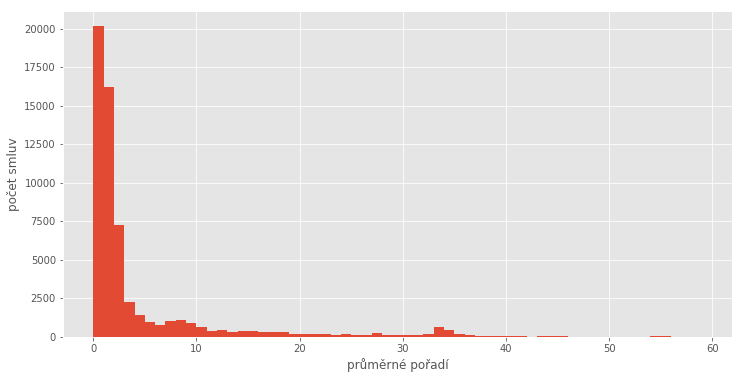

In [8]:
min = np.min(result)
max = np.max(result)

binwidth = 1

fig, axes = plt.subplots()
axes.set_xlabel("průměrné pořadí")
axes.set_ylabel("počet smluv")
axes.hist(result, bins=np.arange((min // binwidth) * binwidth, ((max // binwidth) + 1) * binwidth, binwidth), rwidth=1)
fig.savefig("vystup/model-rbda.pdf", bbox_inches='tight')

In [48]:
import pickle

with open('model/RBDA-e60k.pkl', 'wb') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
import pickle

with open('model/RBDA-comp.pkl', 'wb') as handle:
    pickle.dump(labels[np.argsort(result)[-61:]], handle, protocol=pickle.HIGHEST_PROTOCOL)